In [1]:
from datetime import datetime
import math

from rastervision.pipeline.file_system.utils import json_to_file, file_to_json
from rastervision.core import Box, RasterStats
from rastervision.core.data import (
    RasterioCRSTransformer, StatsTransformer, XarraySource)
from rastervision.core.data.utils import ensure_json_serializable

from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch import nn
import pystac_client
import stackstac
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

---

# Load model

In [2]:
from torch import nn
import torchvision
from torchvision.models import resnet18
from torchvision.transforms import v2
from rastervision.pytorch_learner.utils import adjust_conv_channels

### ImageNet model

In [3]:
BANDS = [
    'red', # B04
    'green', # B03
    'blue', # B02
]

In [4]:
def get_imagenet_model():
    model = resnet18(weights='DEFAULT')
    model.fc = nn.Identity()
    model = model.to(device=DEVICE)
    model = model.eval()
    return model

In [5]:
model = get_imagenet_model()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 41.1MB/s]


In [6]:
stats_tf = StatsTransformer.from_stats_json('data/SSL4EO_stats.json')

In [7]:
imagenet_tf = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()

### SSL4EO model

In [4]:
BANDS = [
    'coastal', # B01
    'blue', # B02
    'green', # B03
    'red', # B04
    'rededge1', # B05
    'rededge2', # B06
    'rededge3', # B07
    'nir', # B08
    'nir08', # B8A
    'nir09', # B09
    'swir16', # ???
    'swir16', # B11
    'swir22', # B12
]

In [ ]:
def get_ssl4eo_model():
    sd = torch.load('data/B13_rn18_moco_0099_ckpt.pth')
    sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
    sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}
    model = resnet18(weights=None)
    model.fc = nn.Identity()
    model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
    model.load_state_dict(sd_encoder_q_no_prefix)
    model = model.to(device=DEVICE)
    model = model.eval()
    return model

In [ ]:
model = get_ssl4eo_model()

In [ ]:
stats_tf = StatsTransformer.from_stats_json('data/SSL4EO_stats.json')

### Clay v1 model

https://huggingface.co/made-with-clay/Clay/

In [ ]:
!mkdir data/clay
!git clone git@github.com:Clay-foundation/model.git data/clay

In [ ]:
%pip install -q lightning pyarrow einops vit_pytorch torchdata

In [33]:
class ClayWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        import sys
        sys.path.append('data/clay/model/')
        from src.datamodule import ClayDataset
        self.model = model
        self._ds = ClayDataset('')

    def forward(self, x: torch.Tensor, dates: list[str], latlons: list[tuple[float, float]]) -> torch.Tensor:
        latlons = [self._ds.normalize_latlon(lon, lat) for lat, lon in latlons]
        dates = [self._ds.normalize_timestamp(t) for t in dates]
        inp = dict(
            pixels=x.to(DEVICE), 
            latlon=torch.as_tensor(latlons).to(x.device), 
            timestep=torch.as_tensor(dates).to(x.device),
        )
        out, _, _, _ = self.model.encoder(inp)
        return out

def get_clay_model():
    import sys
    sys.path.append('data/clay/model/')
    from src.model_clay import CLAYModule
    model = CLAYModule.load_from_checkpoint(
        'https://huggingface.co/made-with-clay/Clay/resolve/main/Clay_v0.1_epoch-24_val-loss-0.46.ckpt',
        mask_ratio=0.0,
        band_groups={'rgb': (2, 1, 0), 'nir': (3,), 'swir': (4, 5)},
        # band_groups={'rgb': (0, 1, 2), 'nir': (3,), 'swir': (4, 5)},
        bands=6,
        strict=False,
    )
    model = model.model
    model = model.to(device=DEVICE)
    model = model.eval()
    model = ClayWrapper(model)
    return model

In [111]:
model = get_clay_model()

In [15]:
c = bbox.to_shapely().centroid
lon, lat = _ds.normalize_latlon(c.x, c.y)

In [32]:
BANDS = [
    'red', # B04
    'green', # B03
    'blue', # B02
    'nir', # B08
    'swir16', # B11
    'swir22', # B12
]

In [33]:
stats_tf = StatsTransformer(
    means=[
        1369.03,  # red
        1597.68,  # green
        1741.10,  # blue
        2893.86,  # nir
        2303.00,  # swir16
        1807.79,  # swir22
    ],
    stds=[
        2026.96,  # red
        2011.88,  # green
        2146.35,  # blue
        1917.12,  # nir
        1679.88,  # swir16
        1568.06,  # swir22
    ]
)

---

## Find images

In [8]:
bbox = Box(xmin=67.882, ymin=27.674, xmax=67.929, ymax=27.825)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=27.674, xmin=67.882, ymax=27.825, xmax=67.929)

In [9]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2017-01-01/2024-04-30',
    query={'eo:cloud_cover': {'lt': 5}},
).item_collection()
len(items)

621

In [10]:
gdf = gpd.GeoDataFrame.from_features(items)

### Convert to a Raster Vision `RasterSource`

In [11]:
raster_source = XarraySource.from_stac(
    items,
    raster_transformers=[stats_tf],
    temporal=True,
    allow_streaming=True,
    stackstac_args=dict(assets=BANDS, rescale=False, fill_value=0),
)

In [44]:
dates = np.array([str(t.date()) for t in raster_source.data_array.time.to_series()])

---

## Generate embeddings

### Run inference

In [14]:
def get_embedding_imagenet(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = imagenet_tf(x)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu()
    return out

def get_embedding_ssl4eo(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu()
    return out

def get_embedding_clay(model: 'ClayWrapper', 
                       x: np.ndarray, 
                       date: str, 
                       latlon: tuple[float, float]) -> torch.Tensor:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x, [date], [latlon])
    out = out.mean(dim=1)
    out = out.cpu()
    return out

In [15]:
window = Box(ymin=1000-6, xmin=6000-6, ymax=1500+6, xmax=6500+6)
window_geom = window.to_shapely()
window_geom_map = raster_source.crs_transformer.pixel_to_map(window_geom)

In [16]:
emb_dims = 512
embeddings = torch.zeros(len(dates), emb_dims)
with torch.inference_mode(), tqdm(dates) as bar:
    for t, date in enumerate(bar):
        bar.set_postfix_str(date)
        chip_t = raster_source.get_chip(window, time=t)
        if chip_t.max() == 0:
            continue
        embeddings[t] = get_embedding_imagenet(model, chip_t).squeeze()

  0%|          | 0/621 [00:00<?, ?it/s]

In [ ]:
emb_dims = 512
embeddings = torch.zeros(len(dates), emb_dims)
with torch.inference_mode(), tqdm(dates) as bar:
    for t, date in enumerate(bar):
        bar.set_postfix_str(date)
        chip_t = raster_source.get_chip(window, time=t)
        if chip_t.max() == 0:
            continue
        embeddings[t] = get_embedding_ssl4eo(model, chip_t).squeeze()

In [114]:
emb_dims = 768
embeddings = torch.zeros(len(dates), emb_dims)
with torch.inference_mode(), tqdm(dates) as bar:
    for t, date in enumerate(bar):
        bar.set_postfix_str(date)
        if not window_geom_map.within(gdf.iloc[t].geometry):
            continue
        chip_t = raster_source.get_chip(window, time=t)
        if chip_t.max() == 0:
            continue
        embeddings[t] = get_embedding_clay(model, chip_t, date, (lat, lon)).squeeze()

  0%|          | 0/621 [00:00<?, ?it/s]

In [17]:
good_dates_mask = embeddings.sum(dim=1) != 0
print('# bad', (~good_dates_mask).sum())

# bad tensor(295)


In [19]:
embeddings = embeddings[good_dates_mask]
dates = dates[good_dates_mask]

In [71]:
embeddings_info = dict(
    embeddings=embeddings, 
    dates=dates, 
)
torch.save(embeddings_info, 'data/embeddings_imagenet.pt')
# torch.save(embeddings_info, 'data/embeddings_clayv0.1_2.pt')
# torch.save(embeddings_info, 'data/embeddings_SSL4EO.pt')

## Analysis

In [72]:
# embeddings_info = torch.load('data/embeddings_SSL4EO.pt')
# embeddings_info = torch.load('data/embeddings_clayv0.1.pt')
embeddings_info = torch.load('data/embeddings_imagenet.pt')
embeddings = embeddings_info['embeddings']
dates = embeddings_info['dates']
embeddings.shape

torch.Size([324, 512])

In [70]:
# N = len(embeddings)
# embeddings = embeddings[np.arange(N) != error.argmax()]
# dates = dates[np.arange(N) != error.argmax()]

In [73]:
embeddings -= embeddings.mean(axis=0)

In [74]:
dates_flood = np.array([
    '2020-07-15', '2020-09-08', '2020-09-18', '2020-09-23',
    '2020-09-28', '2020-10-03', '2020-10-08', '2020-10-18',
    '2020-10-28', '2022-09-03', '2022-09-08', '2022-09-13',
    '2022-09-23', '2022-09-28', '2022-10-03', '2022-10-08',
    '2022-10-13', '2022-10-18', '2022-10-23', '2022-10-28'
])

In [75]:
t_doy = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates])
t_doy_flood = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates_flood])

t_foy = np.clip(t_doy / 365, 0, 1)

In [76]:
def to_t_day(date):
    timetuple = datetime.strptime(date, '%Y-%m-%d').timetuple()
    year = timetuple.tm_year
    doy = np.clip(timetuple.tm_yday / 365, 0, 1)
    return year + doy

In [77]:
t_day = np.array([to_t_day(date) for date in dates])
t_day_flood = np.array([to_t_day(date) for date in dates_flood])

---

### PCA

In [78]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
pca.fit(embeddings)
pca_emb = pca.transform(embeddings)
pca_emb.shape

(324, 324)

### Regression

In [79]:
from sklearn.linear_model import RANSACRegressor
from matplotlib.colors import Normalize

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

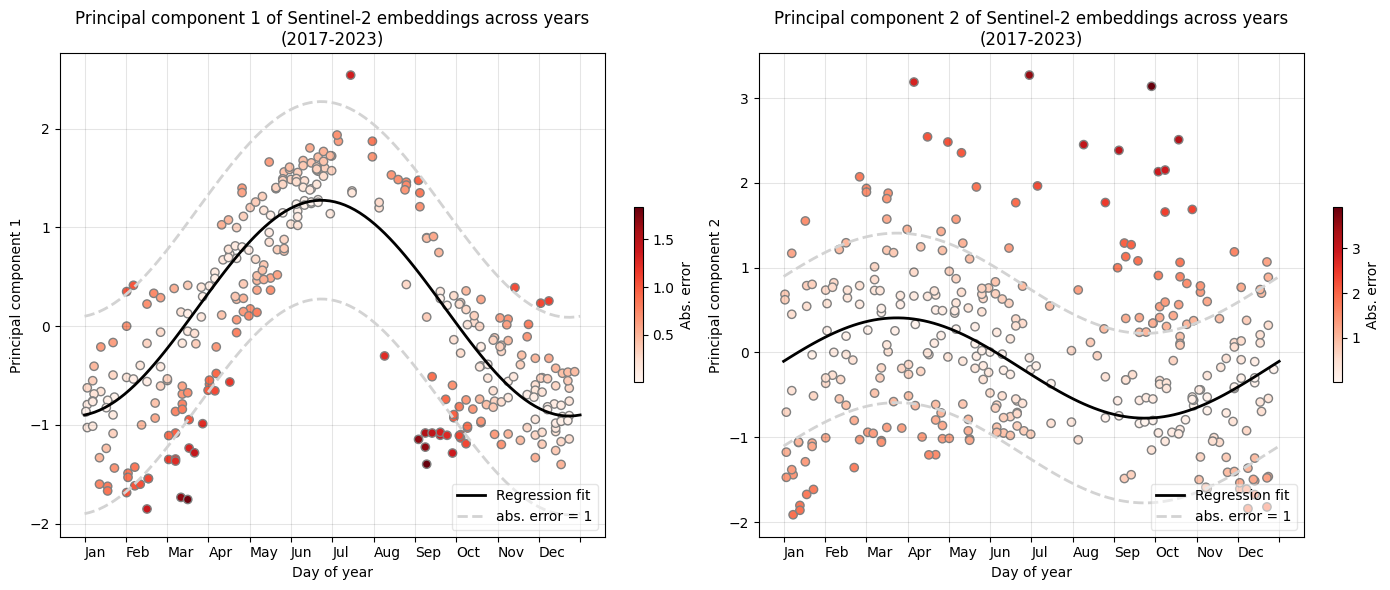

In [87]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(14, 6), squeeze=True, tight_layout=True)
cmap = plt.get_cmap('Reds')

for pc, ax in enumerate(axs.flat):
    lr = RANSACRegressor()
    Y = pca_emb[:, pc]
    X = t_to_feats(t_foy)
    _ = lr.fit(X, Y)

    x = t_foy
    y_pred = lr.predict(t_to_feats(x))
    error = np.abs(y_pred - pca_emb[:, pc])
    norm = Normalize(error.min(), error.max())
    cols = cmap(norm(error))
    ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

    t = np.linspace(0, 1, 100)
    x = t_to_feats(t)
    y_pred = lr.predict(x)
    ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
    ax.plot(t, y_pred + 1, lw=2, c='lightgray', ls='--', label='abs. error = 1')
    ax.plot(t, y_pred - 1, lw=2, c='lightgray', ls='--')
    ax.legend(loc='lower left')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.015, label='Abs. error')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [81]:
pc = 0
lr = RANSACRegressor()
Y = pca_emb[:, pc]
X = t_to_feats(t_foy)
_ = lr.fit(X, Y)

x = t_foy
y_pred = lr.predict(t_to_feats(x))
error = np.abs(y_pred - pca_emb[:, pc])

dates_flood = dates[(t_foy > 0.5) & (error > 1.)]
dates_flood

array(['2020-09-08', '2020-09-18', '2020-09-18', '2020-09-23',
       '2020-09-28', '2020-09-28', '2020-10-03', '2020-10-03',
       '2020-10-08', '2020-10-08', '2020-10-18', '2020-10-18',
       '2020-10-28', '2020-11-02', '2020-12-07', '2022-09-08',
       '2022-09-13', '2022-09-23', '2022-09-28', '2022-10-03',
       '2022-10-08', '2022-10-13', '2023-08-09', '2023-09-03',
       '2023-09-08', '2023-09-13', '2023-09-28', '2023-10-03',
       '2023-10-08'], dtype='<U10')

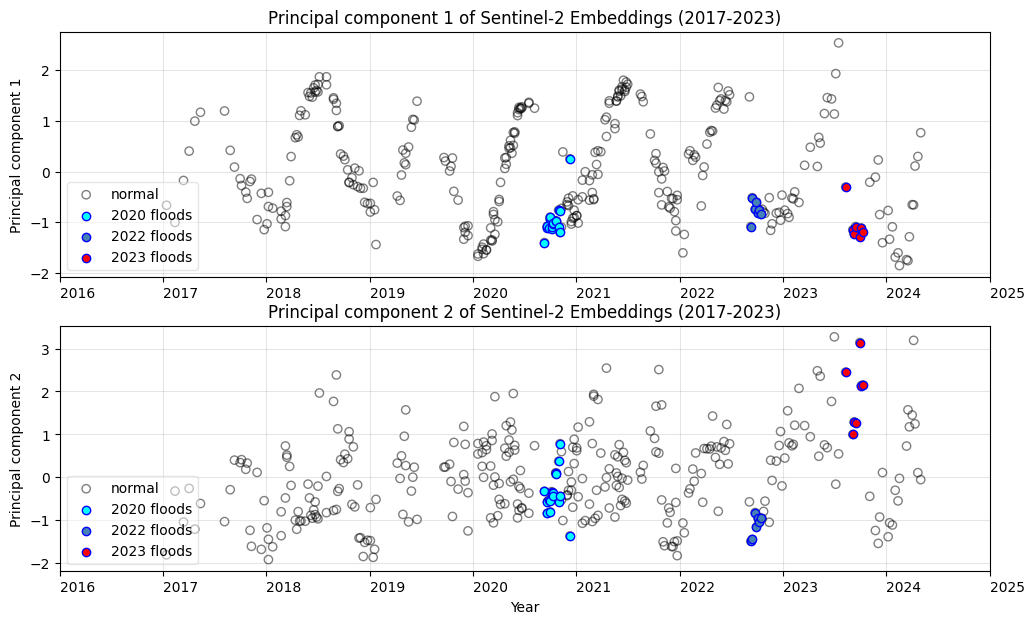

In [82]:
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(12, 7), squeeze=True)

for pc, ax in enumerate(axs):
    ax.scatter(t_day, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_inds_2020 = np.where([date in flood_dates_2020 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2020], pca_emb[flood_inds_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_inds_2022 = np.where([date in flood_dates_2022 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2022], pca_emb[flood_inds_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_day[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower left', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 Embeddings (2017-2023)')
    ax.set_xlim((2016, 2025))
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_ylabel(f'Principal component {pc + 1}')
    if pc == len(axs) - 1:
        ax.set_xlabel('Year')

plt.show()

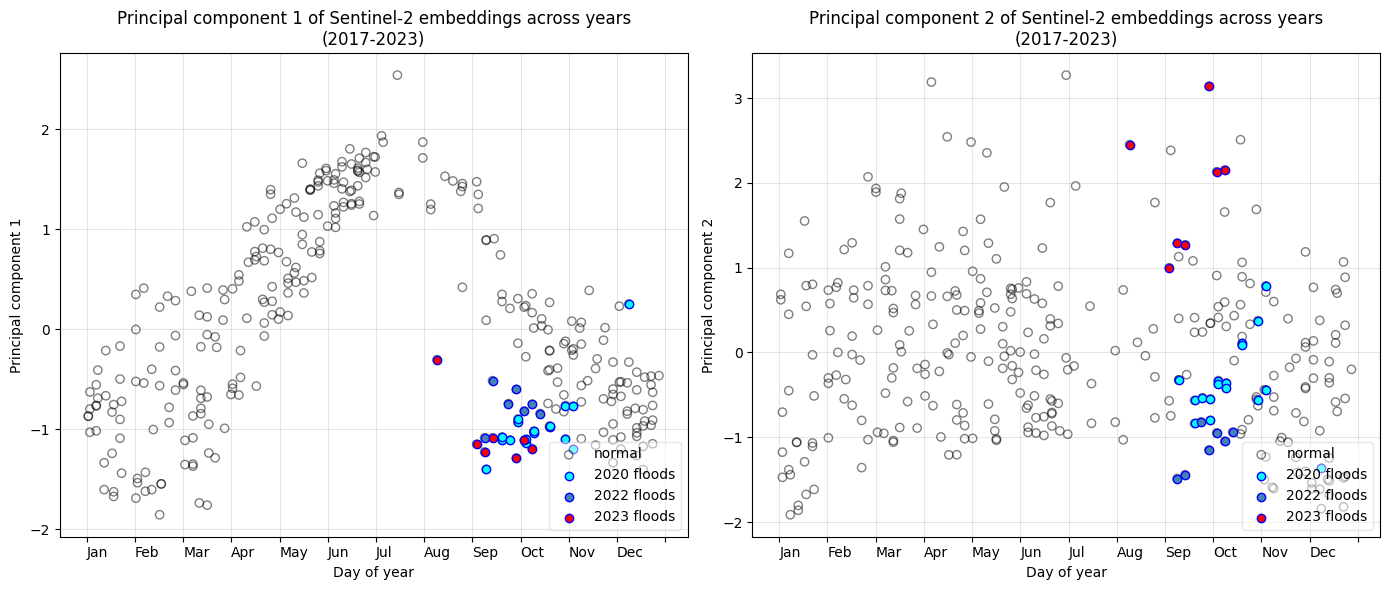

In [83]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(14, 6), squeeze=True, tight_layout=True)

for pc, ax in enumerate(axs.flat):
    ax.scatter(t_foy, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_mask_2020 = np.array([date in flood_dates_2020 for date in dates])
    ax.scatter(t_foy[flood_mask_2020], pca_emb[flood_mask_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_mask_2022 = np.array([date in flood_dates_2022 for date in dates])
    ax.scatter(t_foy[flood_mask_2022], pca_emb[flood_mask_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_foy[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

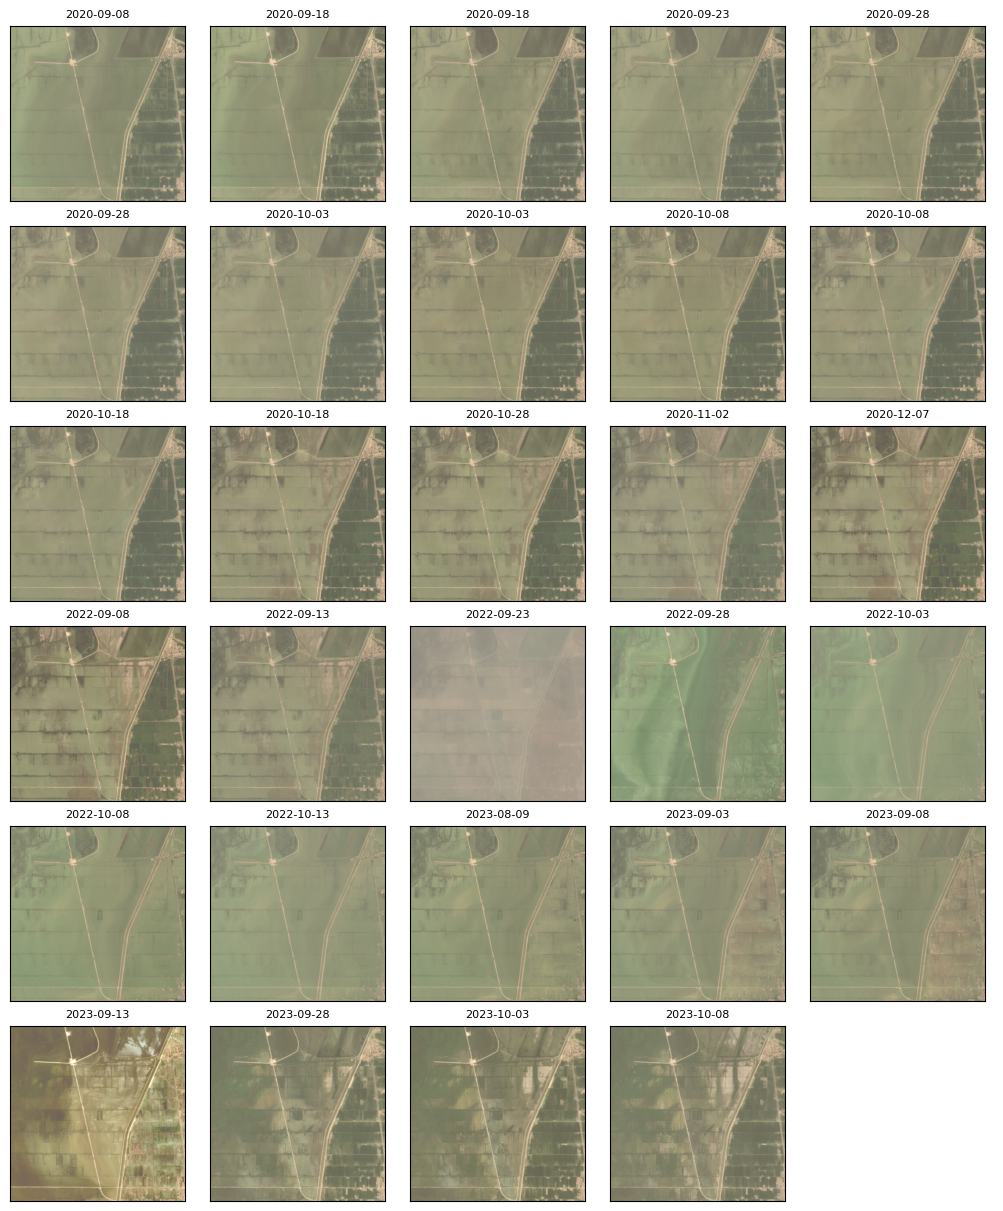

In [84]:
plt.close('all')

ncols = 5
nrows = int(math.ceil(len(dates_flood) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)

dates_data_array = np.array([str(t.date()) for t in raster_source.data_array.time.to_series()])
ts = np.where([date in dates_flood for date in dates_data_array])[0]

with tqdm(zip(ts, dates_flood, axs.flat), total=len(ts)) as bar:
    for i, (t, date, ax) in enumerate(bar):
        chip_t = raster_source.get_chip(window, bands=[0, 1, 2], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(date, fontsize=8)
if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()